In [1]:
import sys
import time
import warnings

# Redirect stderr to a black hole to catch other potential messages
class BlackHole:
    def write(self, message):
        pass
    def flush(self):
        pass
sys.stderr = BlackHole()

# Ignore Python-level UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import helper_utils

helper_utils.set_seed(42)

In [3]:
# # Check device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print(f"Using device: CPU")

Using device: CUDA


In [4]:
class SimpleCNN(nn.Module):
    """A simple Convolutional Neural Network (CNN) architecture.

    This class defines a two-layer CNN with max pooling, dropout, and
    fully connected layers, suitable for basic image classification tasks.
    """
    def __init__(self):
        """Initializes the layers of the neural network."""
        # Initialize the parent nn.Module class
        super(SimpleCNN, self).__init__()
        # First convolutional layer (3 input channels, 16 output channels, 3x3 kernel)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Second convolutional layer (16 input channels, 32 output channels, 3x3 kernel)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Max pooling layer with a 2x2 window and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        # First fully connected (linear) layer
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        # Second fully connected (linear) layer, serving as the output layer
        self.fc2 = nn.Linear(64, 10)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        """Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: The output logits from the network.
        """
        # Apply first convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature maps for the fully connected layers
        x = x.view(-1, 32 * 8 * 8)
        # Apply the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply dropout for regularization
        x = self.dropout(x)
        # Apply the final output layer
        x = self.fc2(x)
        return x


def train_and_evaluate(learning_rate, device, n_epochs=25, batch_size=128, p_bar=None):
    """Orchestrates the training and evaluation of a model for a given configuration.

    This function handles the end-to-end workflow: setting a random seed,
    initializing the model, optimizer, loss function, and dataloaders, and then
    running the main training loop.

    Args:
        learning_rate (float): The learning rate for the optimizer.
        device: The device (e.g., 'cuda' or 'cpu') for training and evaluation.
        n_epochs (int, optional): The number of training epochs. Defaults to 25.
        batch_size (int, optional): The batch size for dataloaders. Defaults to 128.
        p_bar (optional): An existing progress bar handler. Defaults to None.

    Returns:
        dict: A dictionary containing the training and validation history
              (loss and accuracy).
    """
    # Set the random seed for reproducibility
    helper_utils.set_seed(42)

    # Initialize the model and move it to the specified device
    model = SimpleCNN().to(device)

    # Define the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()

    # Prepare the training and validation dataloaders
    train_loader, val_loader = helper_utils.get_dataset_dataloaders(
        batch_size=batch_size
    )

    # Call the main training loop to train the model and get the history
    history = helper_utils.train_model(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        optimizer=optimizer,
        loss_fcn=loss_fn,
        device=device,
        n_epochs=n_epochs,
        p_bar=p_bar
    )

    # Return the collected training history
    return history

In [5]:
# Different learning rates to be analyzed
learning_rates = [0.0002, 0.001, 0.005] # Small, medium, and large learning rates

training_curves = []
n_epochs = 25
batch_size = 128

p_bar = helper_utils.get_p_bar(n_epochs)

# Get the total number of learning rates to check against the index
num_learning_rates = len(learning_rates)

# Train and evaluate the model for each learning rate
for i, lr in enumerate(learning_rates):
    print(f"\nTraining with learning rate: {lr}\n")
    history = train_and_evaluate(learning_rate=lr, n_epochs=n_epochs, batch_size=batch_size, device=device, p_bar=p_bar)
    training_curves.append(history)
    # Only reset the progress bar if it's NOT the last iteration
    if i < num_learning_rates - 1:
        p_bar.reset()

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/10 [00:00<?, ?it/s]


Training with learning rate: 0.0002



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.7640, Training accuracy: 0.3701
At epoch 5: Validation loss: 1.6650, Validation accuracy: 0.4110


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.5529, Training accuracy: 0.4499
At epoch 10: Validation loss: 1.5034, Validation accuracy: 0.4670


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 1.4594, Training accuracy: 0.4718
At epoch 15: Validation loss: 1.4378, Validation accuracy: 0.4930


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 1.3793, Training accuracy: 0.4991
At epoch 20: Validation loss: 1.3795, Validation accuracy: 0.5135


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 1.3224, Training accuracy: 0.5176
At epoch 25: Validation loss: 1.3448, Validation accuracy: 0.5205
Training complete


Training with learning rate: 0.001



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.4864, Training accuracy: 0.4619
At epoch 5: Validation loss: 1.4170, Validation accuracy: 0.4890


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.2967, Training accuracy: 0.5361
At epoch 10: Validation loss: 1.3027, Validation accuracy: 0.5375


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 1.1648, Training accuracy: 0.5757
At epoch 15: Validation loss: 1.2299, Validation accuracy: 0.5650


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 1.0324, Training accuracy: 0.6229
At epoch 20: Validation loss: 1.1856, Validation accuracy: 0.5820


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.9135, Training accuracy: 0.6690
At epoch 25: Validation loss: 1.2275, Validation accuracy: 0.5780
Training complete


Training with learning rate: 0.005



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.4115, Training accuracy: 0.4841
At epoch 5: Validation loss: 1.4073, Validation accuracy: 0.4830


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.1890, Training accuracy: 0.5655
At epoch 10: Validation loss: 1.3146, Validation accuracy: 0.5300


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 1.0149, Training accuracy: 0.6205
At epoch 15: Validation loss: 1.3332, Validation accuracy: 0.5445


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 0.9094, Training accuracy: 0.6590
At epoch 20: Validation loss: 1.3898, Validation accuracy: 0.5525


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.7925, Training accuracy: 0.6924
At epoch 25: Validation loss: 1.5412, Validation accuracy: 0.5530
Training complete



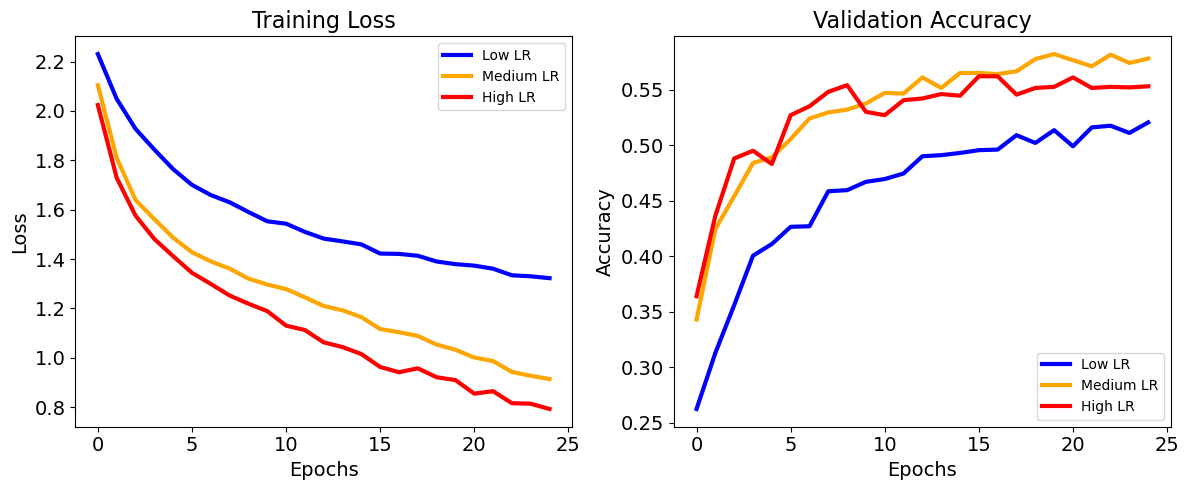

In [6]:
colors = ['blue', 'orange', 'red']
labels = ['Low LR', 'Medium LR', 'High LR']

helper_utils.plot_learning_curves(colors, labels, training_curves)

# Each color corresponds to a different learning rate: blue for low, orange for medium, and red for high.

In [7]:
helper_utils.set_seed(42)

# Initialize the model, optimizer, loss function, and dataloaders
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005) # start with a high learning rate

In [8]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2) # reduce the learning rate by 20% it's prior value

In [9]:
loss_fn = nn.CrossEntropyLoss()

train_loader, val_loader = helper_utils.get_dataset_dataloaders(batch_size=batch_size)

history_LR = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "lr": [],
}


pbar = helper_utils.NestedProgressBar(
    total_epochs=n_epochs,
    total_batches=len(train_loader),
    epoch_message_freq=5,
    mode="train",
)

for epoch in range(n_epochs):
    pbar.update_epoch(epoch+1)

    # Train the model for one epoch
    train_loss, train_acc = helper_utils.train_epoch(model, train_loader, optimizer, loss_fn, device, pbar)

    # Evaluate the model on the validation set
    val_loss, val_acc = helper_utils.evaluate_epoch(model, val_loader, loss_fn, device)

    # Get the current learning rate BEFORE stepping the scheduler.
    # This captures the LR that was just used for the training epoch above.
    current_lr = scheduler.get_last_lr()[0]
    
    # Step the scheduler (updates the LR for the NEXT epoch)
    scheduler.step()
    
    pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}, LR: {current_lr:.6f}")

    pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

    history_LR["train_loss"].append(train_loss)
    history_LR["train_acc"].append(train_acc)
    history_LR["val_loss"].append(val_loss)
    history_LR["val_acc"].append(val_acc)
    history_LR["lr"].append(current_lr)

pbar.close('Training complete with StepLR scheduler')

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.4277, Training accuracy: 0.4809, LR: 0.005000
At epoch 5: Validation loss: 1.3838, Validation accuracy: 0.4900


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 1.1590, Training accuracy: 0.5765, LR: 0.005000
At epoch 10: Validation loss: 1.3233, Validation accuracy: 0.5330


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 0.9419, Training accuracy: 0.6504, LR: 0.001000
At epoch 15: Validation loss: 1.2640, Validation accuracy: 0.5675


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 0.8735, Training accuracy: 0.6695, LR: 0.001000
At epoch 20: Validation loss: 1.2940, Validation accuracy: 0.5620


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.8061, Training accuracy: 0.6991, LR: 0.000200
At epoch 25: Validation loss: 1.3125, Validation accuracy: 0.5675
Training complete with StepLR scheduler


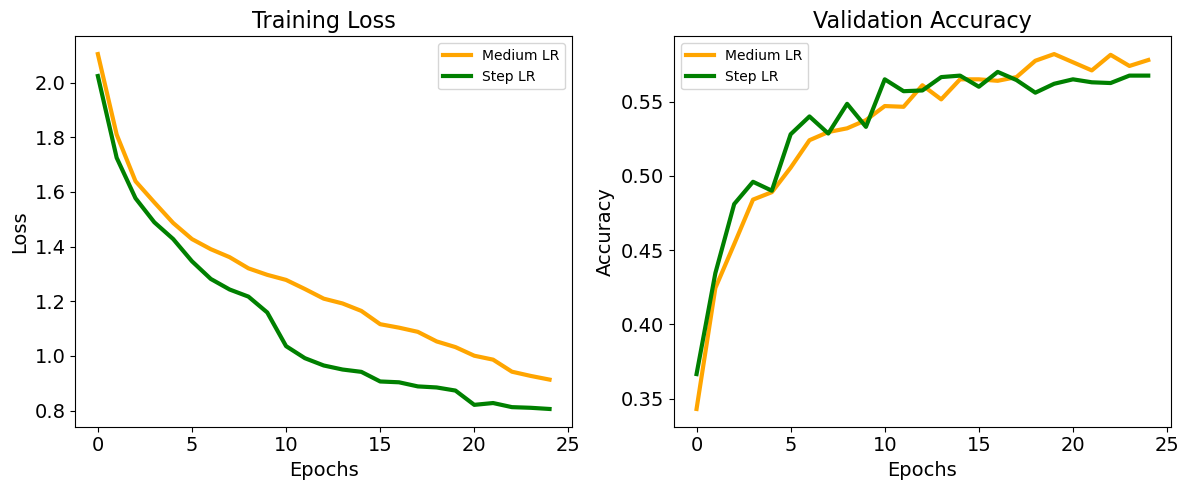

In [10]:
idx = 1
history_constant = training_curves[idx]

colors = ['orange', 'green']
labels = ['Medium LR', 'Step LR']
histories = [history_constant, history_LR]

helper_utils.plot_learning_curves(colors, labels, histories)

In [11]:
def train_and_evaluate_with_scheduler(model, optimizer, scheduler, device, n_epochs=25, batch_size=128):
    """Trains and evaluates a model using a learning rate scheduler.

    Args:
        model: The neural network model to be trained.
        optimizer: The optimization algorithm.
        scheduler: The learning rate scheduler.
        device: The computing device ('cuda' or 'cpu') to run the training on.
        n_epochs: The total number of training epochs.
        batch_size: The number of samples per batch in the data loaders.

    Returns:
        A dictionary containing the training and validation history
        (loss, accuracy, and learning rate) for each epoch.
    """
    # Set the random seed for reproducibility
    helper_utils.set_seed(10)

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()
    # Prepare the training and validation data loaders
    train_loader, val_loader = helper_utils.get_dataset_dataloaders(
        batch_size=batch_size
    )

    # Initialize a dictionary to store training and validation history
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        'lr': [],
    }

    # Initialize the progress bar for monitoring training
    pbar = helper_utils.NestedProgressBar(
        total_epochs=n_epochs,
        total_batches=len(train_loader),
        epoch_message_freq=5,
        mode="train",
    )

    # Loop through the specified number of epochs
    for epoch in range(n_epochs):

        # Update the progress bar for the current epoch
        pbar.update_epoch(epoch+1)

        # Train the model for one epoch
        train_loss, train_acc = helper_utils.train_epoch(model, train_loader, optimizer, loss_fn, device, pbar)
        # Evaluate the model on the validation set
        val_loss, val_acc = helper_utils.evaluate_epoch(model, val_loader, loss_fn, device)
        
        # Retrieve the current learning rate from the scheduler
        current_lr = scheduler.get_last_lr()[0]

        # Update the learning rate based on the scheduler type
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # For schedulers that monitor a metric, pass the metric to the step function
            scheduler.step(val_acc)
        else:
            # For other schedulers, call the step function without arguments
            scheduler.step()
        
        # Log the training metrics for the current epoch, including the learning rate
        pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}, LR: {current_lr:.6f}")

        # Log the validation metrics for the current epoch, including the learning rate
        pbar.maybe_log_epoch(epoch=epoch+1, message=f"At epoch {epoch+1}: Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

        # Append the metrics for the current epoch to the history dictionary
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history['lr'].append(current_lr)

    # Close the progress bar upon completion of training
    pbar.close('Training complete!')
    # Return the collected training and validation history
    return history

In [12]:
# CosineAnnealingLR
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min = 0.0002)

history_cosine = train_and_evaluate_with_scheduler(
    model, optimizer, scheduler_cosine, device, n_epochs=n_epochs, batch_size=batch_size
)

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.2457, Training accuracy: 0.5529, LR: 0.004703
At epoch 5: Validation loss: 1.2473, Validation accuracy: 0.5595


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 0.9151, Training accuracy: 0.6647, LR: 0.003622
At epoch 10: Validation loss: 1.2345, Validation accuracy: 0.5825


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 0.6454, Training accuracy: 0.7604, LR: 0.002150
At epoch 15: Validation loss: 1.3563, Validation accuracy: 0.5900


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 0.4989, Training accuracy: 0.8104, LR: 0.000850
At epoch 20: Validation loss: 1.4654, Validation accuracy: 0.6025


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.4399, Training accuracy: 0.8347, LR: 0.000219
At epoch 25: Validation loss: 1.5238, Validation accuracy: 0.6035
Training complete!


In [13]:
# ReduceLROnPlateau
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

scheduler_plateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3)

history_plateau = train_and_evaluate_with_scheduler(
    model, optimizer, scheduler_plateau, device, n_epochs=n_epochs, batch_size=batch_size
)

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 5: Training loss: 1.2710, Training accuracy: 0.5475, LR: 0.005000
At epoch 5: Validation loss: 1.2195, Validation accuracy: 0.5585


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 10: Training loss: 0.9755, Training accuracy: 0.6475, LR: 0.005000
At epoch 10: Validation loss: 1.2413, Validation accuracy: 0.5695


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 15: Training loss: 0.7322, Training accuracy: 0.7272, LR: 0.005000
At epoch 15: Validation loss: 1.3947, Validation accuracy: 0.5715


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 20: Training loss: 0.6074, Training accuracy: 0.7696, LR: 0.005000
At epoch 20: Validation loss: 1.5959, Validation accuracy: 0.5640


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

At epoch 25: Training loss: 0.3900, Training accuracy: 0.8504, LR: 0.001000
At epoch 25: Validation loss: 1.7092, Validation accuracy: 0.5930
Training complete!


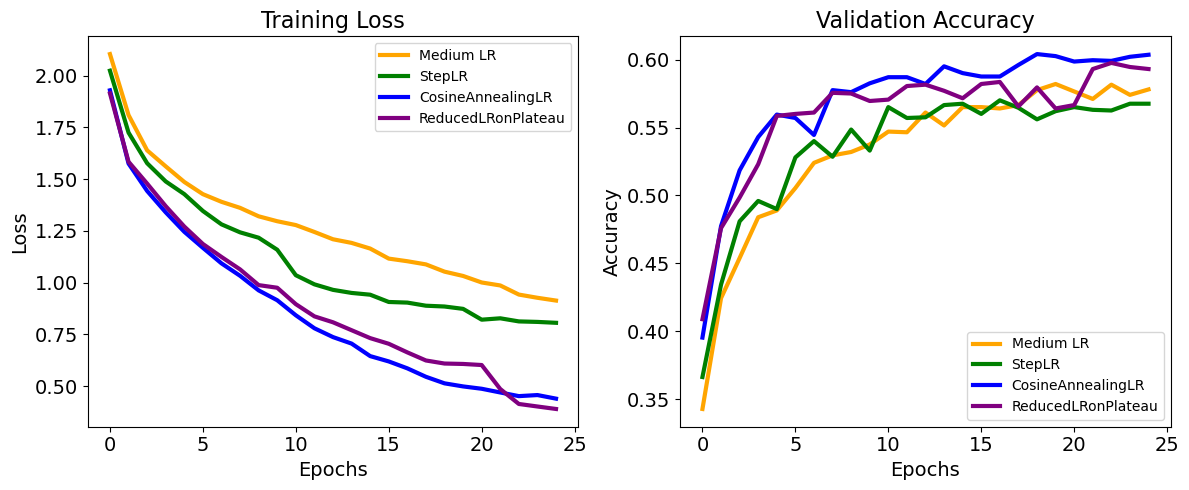

In [14]:
labels = ['Medium LR', 'StepLR', 'CosineAnnealingLR', 'ReducedLRonPlateau']
colors = ['orange', 'green', 'blue', 'purple']

training_curves_new = [history_constant, history_LR, history_cosine, history_plateau]

helper_utils.plot_learning_curves(colors, labels, training_curves_new)

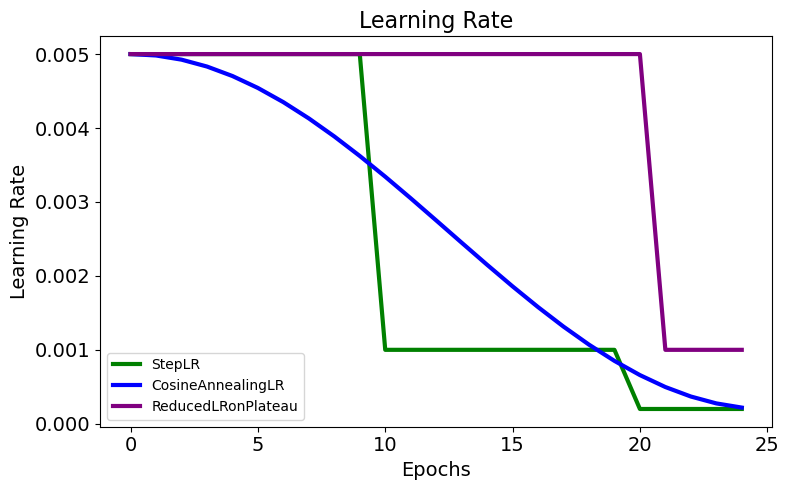

In [15]:
helper_utils.plot_learning_rates_curves(training_curves_new, colors, labels)